### Model Training
In this notebook, we will train a model to predict **medical test results** based on input features. We will use the **Healthcare Dataset**, splitting it into training, validation, and testing sets. Our approach will include:

- Establishing a **baseline model** using Simple Models **(DecisionTreeClassifier, KNN, LogisticRegression)**.
- Choosing the best training approach:
    * Training on the **entire dataset**.
    * Training on a **subset of the most important features** based on **Feature Importance**.
    * Training on a **Dimensionality Reduced version** of the dataset using **UMAP**.
- **Training Advanced Tree-Based Models (XGBoost, LightGBM, Random Forest)** for better generalization and performance.
- **Hyperparameter tuning** using **Optuna** to optimize model performance.
- **Create an ensemble model** using **Stacking** or **Voting** to combine the predictions of the best models.
- Saving the **best model** for Evaluation.

### Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import optuna
optuna.logging.set_verbosity(optuna.logging.ERROR)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score

### Load Datasets

In [2]:
whole_train_data = pd.read_csv('Data_Preprocessed/preprocessed_train.csv')
whole_val_data = pd.read_csv('Data_Preprocessed/preprocessed_val.csv')
reduced_train_data = pd.read_csv('Data_Preprocessed/reduced_train.csv')
reduced_val_data = pd.read_csv('Data_Preprocessed/reduced_val.csv')

### Training Baseline Models

In [3]:
# Baseline Models
def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"{model.__class__.__name__} Accuracy: {acc:.4f}")
    return acc

models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression()
}

for name, model in models.items():
    print(f"Evaluating {name} on whole data")
    evaluate_model(model, 
                   whole_train_data.drop(columns=['Test Results Encoded']), 
                   whole_train_data['Test Results Encoded'], 
                   whole_val_data.drop(columns=['Test Results Encoded']), 
                   whole_val_data['Test Results Encoded'])
    print(f"Evaluating {name} on reduced data")
    evaluate_model(model, 
                   reduced_train_data.drop(columns=['Test Results Encoded']), 
                   reduced_train_data['Test Results Encoded'], 
                   reduced_val_data.drop(columns=['Test Results Encoded']), 
                   reduced_val_data['Test Results Encoded'])
    print("-----------------------------------------------------")


Evaluating Decision Tree on whole data
DecisionTreeClassifier Accuracy: 0.3400
Evaluating Decision Tree on reduced data
DecisionTreeClassifier Accuracy: 0.3120
-----------------------------------------------------
Evaluating KNN on whole data
KNeighborsClassifier Accuracy: 0.3520
Evaluating KNN on reduced data
KNeighborsClassifier Accuracy: 0.3490
-----------------------------------------------------
Evaluating Logistic Regression on whole data
LogisticRegression Accuracy: 0.3200
Evaluating Logistic Regression on reduced data
LogisticRegression Accuracy: 0.3620
-----------------------------------------------------


Logistic Regression trained on reduced data outperforms the other models in terms of accuracy.

### Feature Importance using Decision Tree

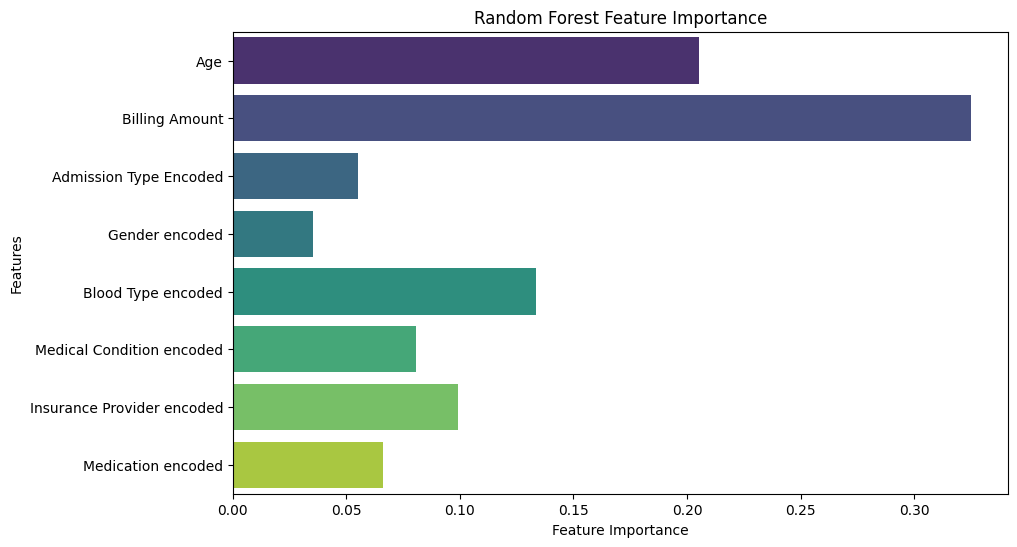

In [38]:
feature_selector = DecisionTreeClassifier(random_state=42)
feature_selector.fit(whole_train_data.drop(columns=['Test Results Encoded']), whole_train_data['Test Results Encoded'])
feature_importance = feature_selector.feature_importances_
feature_names = whole_train_data.drop(columns=['Test Results Encoded']).columns

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_names, palette="viridis")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Random Forest Feature Importance")
plt.show()

### Observations
1. Most Features seem to contribute positively to the model.
2. Dimentionality reduction improved the accuracy of logistic regression model.
3. Dimentionality reduction didn't work with decision tree model.

### Training Complex Models

In [39]:
complex_models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier(verbose=-1),
    "CatBoost": CatBoostClassifier(verbose=0)
}

for name, model in complex_models.items():
    print(f"Evaluating {name} on whole data")
    evaluate_model(model, 
                   whole_train_data.drop(columns=['Test Results Encoded']), 
                   whole_train_data['Test Results Encoded'], 
                   whole_val_data.drop(columns=['Test Results Encoded']), 
                   whole_val_data['Test Results Encoded'])
    print(f"Evaluating {name} on reduced data")
    evaluate_model(model, 
                   reduced_train_data.drop(columns=['Test Results Encoded']), 
                   reduced_train_data['Test Results Encoded'], 
                   reduced_val_data.drop(columns=['Test Results Encoded']), 
                   reduced_val_data['Test Results Encoded'])
    print("-----------------------------------------------------")
    

Evaluating Random Forest on whole data
RandomForestClassifier Accuracy: 0.3170
Evaluating Random Forest on reduced data
RandomForestClassifier Accuracy: 0.3580
-----------------------------------------------------
Evaluating XGBoost on whole data
XGBClassifier Accuracy: 0.3530
Evaluating XGBoost on reduced data
XGBClassifier Accuracy: 0.3500
-----------------------------------------------------
Evaluating LightGBM on whole data
LGBMClassifier Accuracy: 0.3440
Evaluating LightGBM on reduced data
LGBMClassifier Accuracy: 0.3510
-----------------------------------------------------
Evaluating CatBoost on whole data
CatBoostClassifier Accuracy: 0.3550
Evaluating CatBoost on reduced data
CatBoostClassifier Accuracy: 0.3600
-----------------------------------------------------


### Observations
1. Reducing Dimensionality slightly improves models performance.
2. CatBoost is the best model among the ones tested.
3. Reducing Dimensionality didn't improve XGBoost's performance.

### Hyperparameter Tuning

In [40]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0)
    }
    model = XGBClassifier(**params, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    return cross_val_score(model, whole_train_data.drop(columns=['Test Results Encoded']), whole_train_data['Test Results Encoded'], cv=5, scoring='accuracy').mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Train Best XGBoost Model
best_params = study.best_params
print(best_params)

best_xgb = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='mlogloss', random_state=42)

print("Training Final XGBoost Model...")
final_acc = evaluate_model( best_xgb, 
                            reduced_train_data.drop(columns=['Test Results Encoded']), 
                            reduced_train_data['Test Results Encoded'], 
                            reduced_val_data.drop(columns=['Test Results Encoded']), 
                            reduced_val_data['Test Results Encoded'])

{'n_estimators': 96, 'max_depth': 8, 'learning_rate': 0.12985998584804356, 'subsample': 0.9983301648928539}
Training Final XGBoost Model...
XGBClassifier Accuracy: 0.3330


In [41]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'depth': trial.suggest_int('depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'verbose': 0  # Suppress training output
    }
    model = CatBoostClassifier(**params, random_state=42)
    return cross_val_score(model, whole_train_data.drop(columns=['Test Results Encoded']), 
                           whole_train_data['Test Results Encoded'], 
                           cv=5, scoring='accuracy').mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print(best_params)

best_catboost = CatBoostClassifier(**best_params, random_state=42, verbose=0)

print("Training Final CatBoost Model...")
final_acc = evaluate_model( best_catboost, 
                            reduced_train_data.drop(columns=['Test Results Encoded']), 
                            reduced_train_data['Test Results Encoded'], 
                            reduced_val_data.drop(columns=['Test Results Encoded']), 
                            reduced_val_data['Test Results Encoded'])

{'n_estimators': 189, 'depth': 13, 'learning_rate': 0.248921686656}
Training Final CatBoost Model...
CatBoostClassifier Accuracy: 0.3570


In [42]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'n_jobs': -1,  # Use all available cores for efficiency
    }
    model = RandomForestClassifier(**params, random_state=42)
    return cross_val_score(model, whole_train_data.drop(columns=['Test Results Encoded']), 
                           whole_train_data['Test Results Encoded'], 
                           cv=5, scoring='accuracy').mean()

# Run Optuna Optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Train Best Random Forest Model
best_params = study.best_params
print(best_params)

best_rf = RandomForestClassifier(**best_params, random_state=42, verbose=0, n_jobs=-1)

print("Training Final Random Forest Model...")
final_acc = evaluate_model( best_rf, 
                            reduced_train_data.drop(columns=['Test Results Encoded']), 
                            reduced_train_data['Test Results Encoded'], 
                            reduced_val_data.drop(columns=['Test Results Encoded']), 
                            reduced_val_data['Test Results Encoded'])

{'n_estimators': 132, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': None}
Training Final Random Forest Model...
RandomForestClassifier Accuracy: 0.3500


Hyperparameter Tuning didn't improve models performance.

### Ensemble Model

In [ ]:
# Define the base models
base_models = [
    ('xgb', best_xgb),
    ('rf', best_rf),
    ('catboost', best_catboost)
]

# Define a meta-model (Logistic Regression)
meta_model = LogisticRegression()

# Create stacking classifier
stacking_model = StackingClassifier(
    estimators=base_models, 
    final_estimator=meta_model, 
    stack_method='predict_proba'  # For classification problems
)

# Train the stacked model
stacking_model.fit(reduced_train_data.drop(columns=['Test Results Encoded']), reduced_train_data['Test Results Encoded'])

# Evaluate the model
final_acc = evaluate_model(
    stacking_model, 
    reduced_train_data.drop(columns=['Test Results Encoded']), 
    reduced_train_data['Test Results Encoded'], 
    reduced_val_data.drop(columns=['Test Results Encoded']), 
    reduced_val_data['Test Results Encoded']
)

StackingClassifier Accuracy: 0.3340
Final Stacking Model Accuracy: 0.334


### Training Best Models on Training + Validation Data

In [5]:
data = pd.concat([reduced_train_data, reduced_val_data])
data.shape

(9000, 3)

In [6]:
catboost = CatBoostClassifier(verbose=0)
catboost.fit(data.drop(columns=['Test Results Encoded']), data['Test Results Encoded'])

lr = LogisticRegression()
lr.fit(data.drop(columns=['Test Results Encoded']), data['Test Results Encoded'])

rf = RandomForestClassifier()
rf.fit(data.drop(columns=['Test Results Encoded']), data['Test Results Encoded'])

RandomForestClassifier()

### Saving Best Models

In [7]:
import joblib

joblib.dump(catboost, "Saved_Models/catboost.joblib")
joblib.dump(lr, "Saved_Models/logisticRegression.joblib")
joblib.dump(rf, "Saved_Models/randomForest.joblib")

['Saved_Models/randomForest.joblib']